In [29]:
import os
import sys
import json
import random
import matplotlib.pyplot as plt

import cv2 as cv

import torch
from lvis import LVIS
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms import transforms
from torchvision.ops import box_convert

import warnings
warnings.filterwarnings("ignore")

In [30]:
def append_categories(path_1, path_2, outPath):
    with open(path_1, "r") as f:
        eval = json.load(f)
    with open(path_2, "r") as f:
        metadata = json.load(f)

    eval["categories"] = metadata["categories"]
    with open(outPath, "w") as f:
        json.dump(eval, f)

In [31]:
def preprocess(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    for i in range(len(data["annotations"])):
        data["annotations"][i]["category_id"] = data["annotations"][i]["_category_id"]
    with open(json_path, "w") as f:
        json.dump(data, f)

In [32]:
dataPath = os.path.join(os.getcwd(), "data", "EgoObjects")
imgPath = os.path.join(dataPath, "images")

In [33]:
evalPath = os.path.join(dataPath, "ego_objects_eval.json")
categoriesPath = os.path.join(dataPath, "ego_objects_metadata.json")
outPath = os.path.join(dataPath, "ego_objects_eval_all.json")

if not os.path.exists(outPath):
    append_categories(evalPath, categoriesPath, outPath)
    preprocess(outPath)

In [34]:
lvis = LVIS(outPath)

In [35]:
sys.path.append(os.path.join(os.getcwd(), "segment-hq/segment_anything"))

In [36]:
from segment_anything import SamPredictor, sam_model_registry

sam = sam_model_registry["vit_h"](checkpoint=os.path.join(os.getcwd(), "sam-models/sam_hq_vit_h.pth"))
sam.to(torch.device("cuda"))
predictor = SamPredictor(sam)

<All keys matched successfully>


In [37]:
if not os.path.exists("Verdana.ttf"):
    os.system("wget https://github.com/matomo-org/travis-scripts/raw/master/fonts/Verdana.ttf")

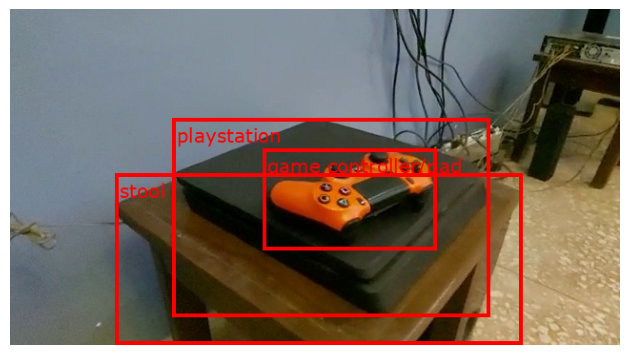

In [38]:
img_ids = lvis.imgs.keys()
img_ids = sorted(img_ids, key=lambda x: random.random())

for img_id in img_ids:
    ann_ids = lvis.get_ann_ids(img_ids = [img_id])
    target = lvis.load_anns(ann_ids)

    path = lvis.load_imgs([img_id])[0]
    path = str(path["group_id"]) + "_" + str(path["video_id"]) + "_" + str(path["frame_id"]) + ".jpg"

    img = cv.imread(os.path.join(imgPath, path))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    toShow = transforms.ToTensor()(img) * 255
    toShow = toShow.type(torch.uint8)

    nums = len(target)
    boxes, labels = [], []
    for i in range(nums):
        x, y, w, h = target[i]['bbox']
        boxes.append([int(x), int(y), int(x + w), int(y + h)])
        label_id = target[i]['category_id']
        label = lvis.cats[label_id]['name']
        labels.append(label)
    boxes = torch.tensor(boxes).type(torch.int64)

    final_img = draw_bounding_boxes(toShow, boxes, labels, colors="red", width=4, font="Verdana.ttf", font_size=20)
    final_img = final_img.permute(1, 2, 0)
    plt.imshow(final_img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

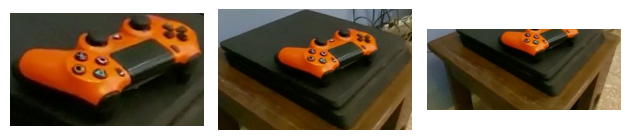

In [39]:
plt.subplot(1, len(boxes), 1)
for idx, box in enumerate(boxes):
    plt.subplot(1, len(boxes), idx + 1)
    crop_img = img[box[1]:box[3], box[0]:box[2], :]
    plt.imshow(crop_img)
    plt.axis('off')
plt.tight_layout()
plt.show()

--- 

# Only Bbox Input prompts

In [40]:
image = cv.imread(os.path.join(imgPath, path))
image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

boxes = boxes.to(predictor.device)
sam_boxes = predictor.transform.apply_boxes_torch(boxes, image.shape[:2])

predictor.set_image(image)
masks, *_ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=sam_boxes,
    multimask_output=False,
    hq_token_only=False
)

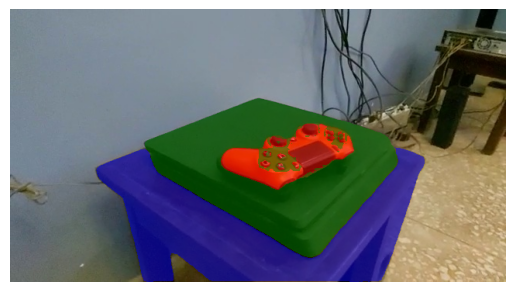

In [41]:
colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "cyan", "magenta", "lime", "teal", "indigo", "maroon", "navy", "olive", "silver", "aqua", "fuchsia", "gray", "black", "white"]

masks = masks.reshape(-1, *image.shape[:2])
mask_img = transforms.ToTensor()(image)
for i, mask in enumerate(masks):
    mask_img = draw_segmentation_masks(mask_img, mask.unsqueeze(0), colors=colors[i], alpha=0.5)
mask_img = mask_img.permute(1, 2, 0)
plt.imshow(mask_img)
plt.axis('off')
plt.show()

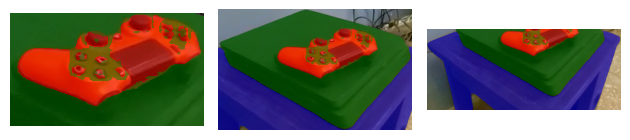

In [42]:
plt.subplot(1, len(boxes), 1)
for idx, box in enumerate(boxes):
    plt.subplot(1, len(boxes), idx + 1)
    crop_img_2 = mask_img[box[1]:box[3], box[0]:box[2], :]
    plt.imshow(crop_img_2)
    plt.axis('off')
plt.tight_layout()
plt.show()